In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
    fname.append('ephys_data/steinmetz_part%d.npz'%j)

In [3]:
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

In [4]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('ephys_data/steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [5]:
alldat[0].keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

alldat contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

dat['mouse_name']: mouse name

dat['date_exp']: when a session was performed

dat['spks']: neurons by trials by time bins.

dat['brain_area']: brain area for each neuron recorded.

dat['ccf']: Allen Institute brain atlas coordinates for each neuron.

dat['ccf_axes']: axes names for the Allen CCF.

dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.

dat['contrast_left']: contrast level for left stimulus.

dat['gocue']: when the go cue sound was played.

dat['response_time']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.

dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.

dat['feedback_time']: when feedback was provided.

dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).

dat['wheel']: turning speed of the wheel that the mice uses to make a response, sampled at 10ms.

dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.

dat['face']: average face motion energy from a video camera.

dat['licks']: lick detections, 0 or 1.

dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".

dat['%X%_passive']: same as above for X = {spks, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.

dat['prev_reward']: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.

dat['reaction_time']: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above 5 ticks/10ms bin. Second column: direction of the wheel movement (0 = no move detected).

The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

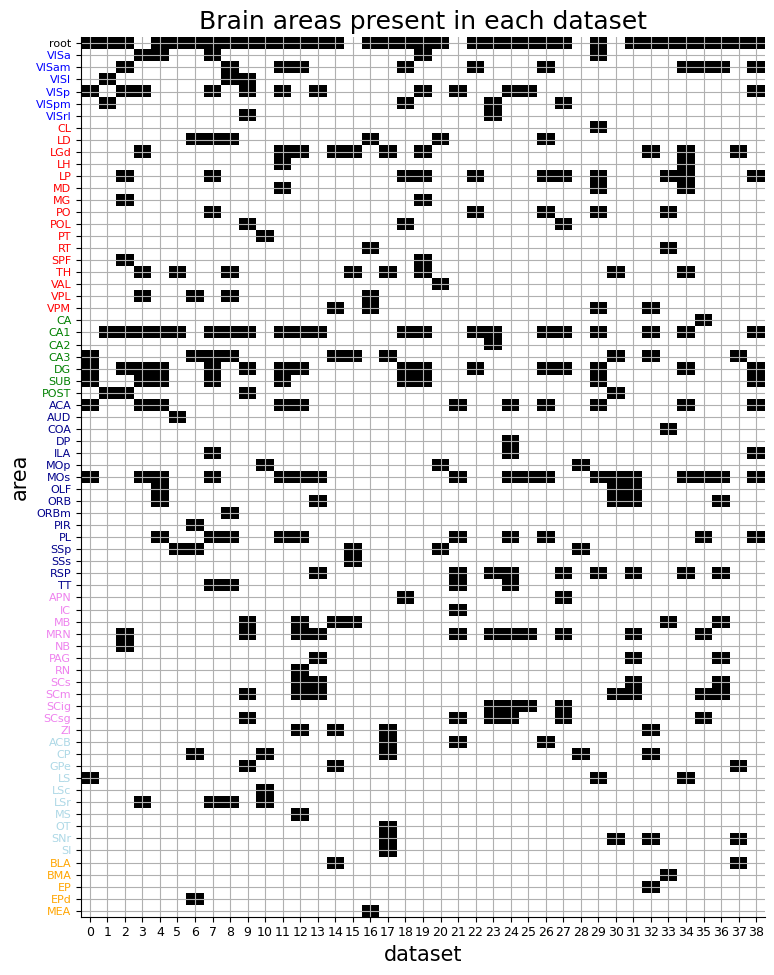

In [6]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

## Analysis

In [69]:
labels_vis = brain_groups[0]  # visual cortex
labels_hpc = brain_groups[2]  # hippocampus

In [93]:
all_hpc_spks = []
all_hpc_fr = []
all_hpc_avg_fr = []
all_hpc_avg_fr_zscored = []
time_window = 0.5  #s
for exp_n, exp in enumerate(alldat):
    indxs_hpc = [i for i, area in enumerate(alldat[exp_n]['brain_area']) if area in labels_hpc]
    dt = alldat[exp_n]['bin_size']
    indx_stim_onset = int(alldat[exp_n]['stim_onset'] / dt)
    indx_cutoff = indx_stim_onset + int(time_window / dt)
    if len(indxs_hpc) > 0:
        spks_hpc = [alldat[exp_n]['spks'][i] for i in indxs_hpc if np.any(alldat[exp_n]['spks'][i][:,indx_stim_onset:indx_cutoff])]
        spks_hpc = np.transpose(spks_hpc, (1,0,2))
        if spks_hpc.shape[1] > 100:
            all_hpc_spks.append(spks_hpc)
            
            fr = spks_hpc / dt
            all_hpc_fr.append(fr)

            fr_ = fr[:, :, indx_stim_onset:indx_cutoff]
            avg_fr = np.mean(fr_, axis=2)
            all_hpc_avg_fr.append(avg_fr)

            fr_centered = avg_fr - np.mean(avg_fr, axis=0)[np.newaxis, :]
            fr_zscored = fr_centered / (np.std(avg_fr, axis=0)[np.newaxis, :] + 1e-10)
            all_hpc_avg_fr_zscored.append(fr_zscored)

In [94]:
all_vis_spks = []
all_vis_fr = []
all_vis_avg_fr = []
all_vis_avg_fr_zscored = []
time_window = 0.5  #s
for exp_n, exp in enumerate(alldat):
    indxs_vis = [i for i, area in enumerate(alldat[exp_n]['brain_area']) if area in labels_vis]
    dt = alldat[exp_n]['bin_size']
    indx_stim_onset = int(alldat[exp_n]['stim_onset'] / dt)
    indx_cutoff = indx_stim_onset + int(time_window / dt)
    if len(indxs_vis) > 0:
        spks_vis = [alldat[exp_n]['spks'][i] for i in indxs_vis if np.any(alldat[exp_n]['spks'][i][:,indx_stim_onset:indx_cutoff])]
        spks_vis = np.transpose(spks_vis, (1,0,2))
        if spks_vis.shape[1] > 100:
            all_vis_spks.append(spks_vis)
            
            fr = spks_vis / dt
            all_vis_fr.append(fr)

            fr_ = fr[:, :, indx_stim_onset:indx_cutoff]
            avg_fr = np.mean(fr_, axis=2)
            all_vis_avg_fr.append(avg_fr)

            fr_centered = avg_fr - np.mean(avg_fr, axis=0)[np.newaxis, :]
            fr_zscored = fr_centered / (np.std(avg_fr, axis=0)[np.newaxis, :] + 1e-10)
            all_vis_avg_fr_zscored.append(fr_zscored)

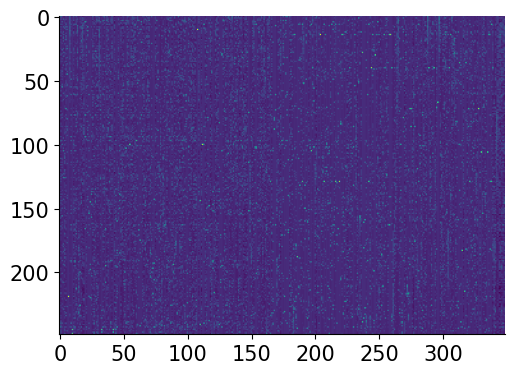

In [96]:
plt.imshow(all_hpc_avg_fr_zscored[3])

In [97]:
start_fit = 2
cutoff_fit = 50

fit_slopes_hpc = []
fit_intercepts_hpc = []
all_variances_hpc = []
for fr in all_hpc_avg_fr_zscored:
    if fr.shape[1] >= 90 :
        fr_pca = PCA().fit(fr)
        variances = fr_pca.explained_variance_ratio_

        x = np.arange(1, len(variances)+1)
        y = variances
        m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)

        fit_slopes_hpc.append(m)
        fit_intercepts_hpc.append(b)
        all_variances_hpc.append(variances)

In [99]:
start_fit = 2
cutoff_fit = 50

fit_slopes_vis = []
fit_intercepts_vis = []
all_variances_vis = []
for fr in all_vis_avg_fr_zscored:
    if fr.shape[1] >= 90 :
        fr_pca = PCA().fit(fr)
        variances = fr_pca.explained_variance_ratio_

        x = np.arange(1, len(variances)+1)
        y = variances
        m, b = np.polyfit(np.log(x[start_fit:cutoff_fit]), np.log(y[start_fit:cutoff_fit]), 1)

        fit_slopes_vis.append(m)
        fit_intercepts_vis.append(b)
        all_variances_vis.append(variances)

In [101]:
plt.figure(figsize=(16,10), dpi=600)

plt.suptitle('Hippocampus', fontsize=18)

for i, variances in enumerate(all_variances_hpc):
    plt.subplot(3, 6, i+1)

    x = np.arange(1, len(variances)+1)
    y = variances

    plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)
    
    m = fit_slopes_hpc[i]
    b = fit_intercepts_hpc[i]
    
    x_fit = x
    y_fit = np.exp(b) * x_fit**m
    plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

    plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)
    
    plt.xlabel('PC dim.', fontsize=12)
    plt.ylabel('Var.', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')

    plt.ylim(1e-3, 1e-1)

    sb.despine()

plt.tight_layout()

#plt.savefig('plots/ephysData_powerLawFits_hpc.png', dpi=600)

plt.show()

In [108]:
plt.figure(figsize=(16,10), dpi=600)

plt.suptitle('Visual Cortex', fontsize=18)

for i, variances in enumerate(all_variances_vis):
    plt.subplot(3, 6, i+1)

    x = np.arange(1, len(variances)+1)
    y = variances

    plt.plot(x, y, color='blue', linewidth=3, alpha=0.8)
    
    m = fit_slopes_vis[i]
    b = fit_intercepts_vis[i]
    
    x_fit = x
    y_fit = np.exp(b) * x_fit**m
    plt.plot(x_fit, y_fit, linestyle='--', color='black', linewidth=1.5)

    plt.title('$\u03B1$='+str(np.around(m, 2)), fontsize=12)
    
    plt.xlabel('PC dim.', fontsize=12)
    plt.ylabel('Var.', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')

    plt.ylim(1e-3, 1e-1)

    sb.despine()

plt.tight_layout()

#plt.savefig('plots/ephysData_powerLawFits_vis.png', dpi=600)

plt.show()

In [104]:
from scipy.stats import pearsonr

def compute_pairwise_correlations(data):
    """
    Compute the overall pairwise correlation level for each session of each animal.

    Parameters:
    data (dict): A nested dictionary where the first key is the animal ID and the second key is the session ID, 
                 mapping to a data matrix for that session.
    p_value_threshold (float): The threshold for considering correlations as significant.

    Returns:
    correlations (dict): A nested dictionary with the mean correlation for each session of each animal.
    """
    n_neurons = data.shape[1]
    correlations = []
    for i in range(n_neurons):
        #print(str(i)+'/'+str(n_neurons))
        for j in range(i+1, n_neurons):
            corr, p_value = pearsonr(data[:, i], data[:, j])
            correlations.append(corr)

    return correlations

In [105]:
all_correlations_vis = []
for exp in all_vis_avg_fr_zscored:
    all_correlations_vis += compute_pairwise_correlations(exp)

In [106]:
all_correlations_hpc = []
for exp in all_hpc_avg_fr_zscored:
    all_correlations_hpc += compute_pairwise_correlations(exp)

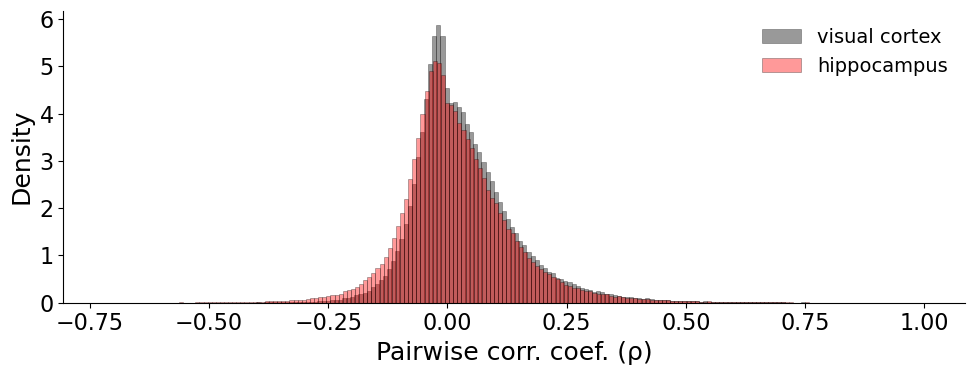

In [107]:
plt.figure(figsize=(10,4))

plt.hist(all_correlations_vis, bins=200, color='k', alpha=.4, edgecolor='k', linewidth=.5, density=True, label='visual cortex')
plt.hist(all_correlations_hpc, bins=200, color='r', alpha=.4, edgecolor='k', linewidth=.5, density=True, label='hippocampus')

#plt.axvline(x=np.mean(all_correlations), color='white', linestyle='--')

plt.xlabel('Pairwise corr. coef. (ρ)', fontsize=18)
#plt.ylabel('No. of neuron pairs', fontsize=18)
plt.ylabel('Density', fontsize=18)

#plt.title('Visual Cortex', fontsize=22)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#plt.xlim(-0.05, 0.1)

plt.legend(frameon=False, fontsize=14)

sb.despine()
plt.tight_layout()
#plt.savefig('plots/pairwiseCorrDistr_CA1.png', dpi=600)
plt.show()